In [1]:
import geopandas as gpd
import vaex
import pandas as pd
import numpy as np

/home/fernando/miniconda3/envs/dash/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
atributo = 'TO médio'
ano = [1995, 2002]

In [5]:
gdf_distritos = gpd.read_file('data/SIRGAS_GPKG_distrito.gpkg')

In [6]:
distrito = gdf_distritos[gdf_distritos.ds_codigo == '90']

In [7]:
# Abrindo arquivo de lote apropriado
path = f'lotes_agregados_por_ano/{ano[0]}/SIRGAS_SHP_LOTES_{distrito.iloc[0].ds_codigo.rjust(2, "0")}_{distrito.iloc[0].ds_nome.replace(" ", "_")}_IPTU_{ano[0]}.gpkg'
print(path)

lotes_agregados_por_ano/1995/SIRGAS_SHP_LOTES_90_VILA_MARIANA_IPTU_1995.gpkg


In [8]:
gdf_lote = gpd.read_file(path).drop_duplicates(subset=['sqlc']).set_index('sqlc')
gdf_lote = gdf_lote[gdf_lote.is_valid]

In [10]:
df_iptu = vaex.open(f'data/por_distritos/IPTU-1995-2022-agrupados-por-sqlc-{distrito.iloc[0].ds_codigo.rjust(2, "0")}-{distrito.iloc[0].ds_nome.replace(" ", "-").lower()}.hdf5').to_pandas_df().set_index('sqlc')
df_iptu_ano = df_iptu[df_iptu.ano == ano[0]]

In [25]:
df_iptu[(df_iptu.ano >= ano[0]) & (df_iptu.ano <= ano[-1])][['ano', atributo]].reset_index()#.pivot(index='sqlc', columns='ano', values=atributo)

,sqlc,ano,TO médio
0,034077004600,1995,0.684211
1,034077004600,1996,0.684211
2,034077004600,1997,0.684211
3,034077004600,1998,0.684211
4,034077004600,1999,0.684211
...,...,...,...
142061,042019031700,2001,0.000000
142062,042019031700,2002,0.532847
142063,042075000005,2001,0.583333
142064,042075000005,2002,0.583333


In [12]:
df_iptu_ano.shape, gdf_lote.shape

((18176, 29), (15209, 3))

In [13]:
np.unique(df_iptu_ano.index.duplicated()), np.unique(gdf_lote.index.duplicated(), return_counts=True)

(array([False]), (array([False]), array([15209])))

In [14]:
## Lotes existentes no IPTU no ano escolhido e com geometria do lote
lotes_existentes = gdf_lote.join(df_iptu_ano, how='inner')

In [16]:
# Lotes sem geometria que foram desmembrados ou remembrados e pprecisam ser agregados
lotes_sg = df_iptu_ano.join(gdf_lote, how='left').sq.isna()
df_lotes_sg = df_iptu_ano[lotes_sg].reset_index()

In [17]:
df_lotes_sg.sqlc = df_lotes_sg.sqlc.str[:6] + '000000'
df_lotes_sg_group = df_lotes_sg.groupby('sqlc').agg(
    {'ano':'first',
    'Quantidade de Unidades':'sum',
    'Quantidade de Unidades Condominiais':'sum',
    'Tamanho Médio da Unidade Condominial':'mean',
    'Tamanho médio dos Terrenos':'mean',
    'Área Total dos terrenos-lotes':'sum',
    'Área Total Ocupada':'sum',
    'Área Total Construída':'sum',
    'Valor Total dos Terrenos':'sum',
    'Valor Total das Construções':'sum',
    'CA médio':'mean',
    'TO médio':'mean',
    'CA médio em lotes condominiais':'mean',
    'TO médio em lotes condominiais':'mean',
    'CA médio em lotes não condominiais':'mean',
    'TO médio em lotes não condominiais':'mean',
    'Comprimento Médio da Testada':'mean',
    'Número médio de Pavimentos':'mean',
    'Fator de obsolecência médio':'mean',
    'Residencial':'mean',
    'Comercial':'mean',
    'Serviços':'mean',
    'Industrial':'mean',
    'Outros':'mean',
    'Percentual de Uso Residencial':'mean',
    'Percentual de Uso Comercial':'mean',
    'Percentual de Uso Serviços':'mean',
    'Percentual de Uso Industrial':'mean',
    'Percentual de Uso Outros':'mean'}
)
# df_lotes_sg.set_index('sqlc')

In [18]:
# Agora com as geometrias
lotes_agregados = gdf_lote.join(df_lotes_sg_group, how='inner')

In [19]:
lotes_existentes.shape, lotes_agregados.shape

((14834, 32), (355, 32))

<AxesSubplot:>

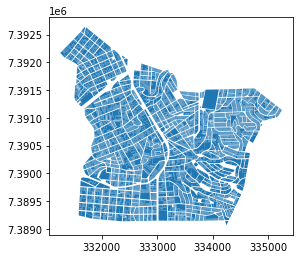

In [22]:
pd.concat([lotes_existentes, lotes_agregados])